# TP5: Knowledge Graph RAG with Ollama & LangChain

This notebook demonstrates how to:
1. Build a knowledge graph from unstructured Wikipedia text
2. Extract entities and relationships using LLMs
3. Create a RAG (Retrieval-Augmented Generation) system
4. Query the knowledge graph using natural language

**Technologies**: Neo4j, LangChain, Ollama, Diffbot, Wikipedia

## 1. Setup and Configuration

In [1]:
# Import required libraries
import os
import json
from dotenv import load_dotenv
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyvis.network import Network

# LangChain imports
from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate

# Load environment variables
load_dotenv()

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Import required libraries
import os
import json
from dotenv import load_dotenv
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyvis.network import Network

# LangChain imports
from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate

# Load environment variables
load_dotenv()

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [3]:
# Configuration
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://neo4j:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "password123")
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://host.docker.internal:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "gemma:2b")

print(f"Neo4j URI: {NEO4J_URI}")
print(f"Ollama Base URL: {OLLAMA_BASE_URL}")
print(f"Ollama Model: {OLLAMA_MODEL}")

Neo4j URI: bolt://neo4j:7687
Ollama Base URL: http://host.docker.internal:11434
Ollama Model: gemma3:4b


In [4]:
# Create persistent Neo4j driver
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Test the connection
try:
    with driver.session() as session:
        result = session.run("RETURN 'Connection successful!' AS message")
        print(result.single()["message"])
    print("✓ Neo4j connection established")
    print(f"✓ Driver available for use in subsequent cells")
except Exception as e:
    print(f"✗ Failed to connect to Neo4j: {e}")
    print("  Check that Neo4j container is running: docker ps | grep neo4j")
    raise

Connection successful!
✓ Neo4j connection established
✓ Driver available for use in subsequent cells



📊 Knowledge Graph Statistics:
  • Articles: 3
  • Entities: 240
  • People: 23
  • Organizations: 22
  • Locations: 22
  • Relationships: 257


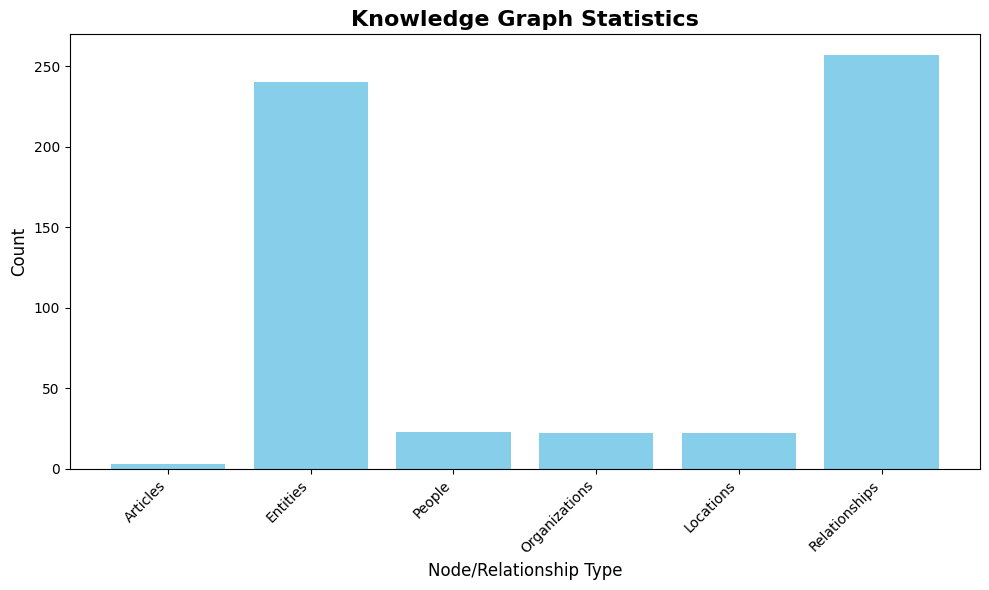


✓ Statistics chart saved to media/graph_statistics.png


In [5]:
# Get database statistics
def get_graph_stats():
    """Get statistics about the knowledge graph"""
    stats_queries = {
        "Articles": "MATCH (a:Article) RETURN count(a) as count",
        "Entities": "MATCH (e:Entity) RETURN count(e) as count",
        "People": "MATCH (p:Person) RETURN count(p) as count",
        "Organizations": "MATCH (o:Organization) RETURN count(o) as count",
        "Locations": "MATCH (l:Location) RETURN count(l) as count",
        "Relationships": "MATCH ()-[r]->() RETURN count(r) as count",
    }
    
    stats = {}
    with driver.session() as session:
        for label, query in stats_queries.items():
            result = session.run(query)
            stats[label] = result.single()["count"]
    
    return stats

stats = get_graph_stats()
print("\n📊 Knowledge Graph Statistics:")
for label, count in stats.items():
    print(f"  • {label}: {count}")

# Visualize statistics
plt.figure(figsize=(10, 6))
plt.bar(stats.keys(), stats.values(), color='skyblue')
plt.title('Knowledge Graph Statistics', fontsize=16, fontweight='bold')
plt.xlabel('Node/Relationship Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/workspace/media/graph_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Statistics chart saved to media/graph_statistics.png")

In [6]:
# Get all articles
def get_articles():
    """Get all articles in the knowledge graph"""
    query = """
    MATCH (a:Article)
    RETURN a.title as title, a.url as url, a.summary as summary
    ORDER BY a.title
    """
    
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([dict(record) for record in result])

articles_df = get_articles()
print(f"\n📚 Found {len(articles_df)} articles:")
display(articles_df)


📚 Found 3 articles:


,title,url,summary
0,Albert Einstein,https://en.wikipedia.org/wiki/Albert_Einstein,Albert Einstein (14 March 1879 – 18 April 1955...
1,Isaac Newton,https://en.wikipedia.org/wiki/Isaac_Newton,Sir Isaac Newton ( ; 4 January [O.S. 25 Decemb...
2,Marie Curie,https://en.wikipedia.org/wiki/Marie_Curie,Maria Salomea Skłodowska-Curie (Polish: [ˈmarj...


In [7]:
# Get top entities by type
def get_top_entities(entity_type=None, limit=10):
    """Get top entities by salience"""
    type_filter = f":{entity_type}" if entity_type else ""
    
    query = f"""
    MATCH (e:Entity{type_filter})
    OPTIONAL MATCH (a:Article)-[m:MENTIONS]->(e)
    WITH e, count(a) as mention_count, avg(m.salience) as avg_salience
    RETURN e.name as name, e.type as type, mention_count, 
           round(avg_salience, 3) as avg_salience
    ORDER BY mention_count DESC, avg_salience DESC
    LIMIT {limit}
    """
    
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([dict(record) for record in result])

print("\n🔝 Top 10 Entities Overall:")
top_entities = get_top_entities(limit=10)
display(top_entities)


🔝 Top 10 Entities Overall:


,name,type,mention_count,avg_salience
0,physics,Entity,3,0.316
1,physicist,Entity,3,0.000
2,2,Entity,3,0.000
3,Nobel Prize in Physics,Entity,2,0.894
4,Nobel Prize,Entity,2,0.746
5,Germany,Entity,2,0.537
6,University,Organization,2,0.500
7,Kingdom,Person,2,0.500
8,In,Location,2,0.500
9,Physics,Organization,2,0.500


In [8]:
# Get entities by type
print("\n👤 Top People:")
display(get_top_entities("Person", 5))

print("\n🏢 Top Organizations:")
display(get_top_entities("Organization", 5))

print("\n📍 Top Locations:")
display(get_top_entities("Location", 5))


👤 Top People:


,name,type,mention_count,avg_salience
0,Nobel Prize,Entity,2,0.746
1,University,Organization,2,0.500
2,Kingdom,Person,2,0.500
3,Albert Einstein,Entity,1,0.997
4,Warsaw,Entity,1,0.994



🏢 Top Organizations:


,name,type,mention_count,avg_salience
0,Nobel Prize,Entity,2,0.746
1,Germany,Entity,2,0.537
2,University,Organization,2,0.500
3,Kingdom,Person,2,0.500
4,Physics,Organization,2,0.500



📍 Top Locations:


,name,type,mention_count,avg_salience
0,In,Location,2,0.500
1,University,Organization,2,0.500
2,Kingdom,Person,2,0.500
3,Warsaw,Entity,1,0.994
4,Marie Curie,Entity,1,0.990


## 3. Visualize the Knowledge Graph

In [9]:
# Visualize a subset of the graph
def visualize_graph(limit=50):
    """Create an interactive visualization of the knowledge graph"""
    query = f"""
    MATCH (a:Article)-[m:MENTIONS]->(e:Entity)
    RETURN a.title as source, e.name as target, e.type as entity_type, 
           m.salience as salience
    ORDER BY m.salience DESC
    LIMIT {limit}
    """
    
    with driver.session() as session:
        result = session.run(query)
        edges = [dict(record) for record in result]
    
    # Create NetworkX graph
    G = nx.DiGraph()
    
    for edge in edges:
        G.add_edge(
            edge['source'], 
            edge['target'],
            entity_type=edge['entity_type'],
            salience=edge['salience']
        )
    
    # Create PyVis network
    net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
    net.from_nx(G)
    
    # Customize node colors by type
    for node in net.nodes:
        if node['id'] in [edge['source'] for edge in edges]:
            node['color'] = '#FF6B6B'  # Articles in red
            node['size'] = 30
        else:
            node['color'] = '#4ECDC4'  # Entities in teal
            node['size'] = 20
    
    # Save and display
    net.save_graph('/workspace/media/knowledge_graph.html')
    print(f"✓ Graph visualization saved to media/knowledge_graph.html")
    print(f"  Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
    
    return G

graph = visualize_graph(limit=50)

✓ Graph visualization saved to media/knowledge_graph.html
  Nodes: 49, Edges: 50


## 4. Cypher Query Exploration

In [10]:
# Helper function to run Cypher queries
def run_cypher(query, params=None):
    """Execute a Cypher query and return results as DataFrame"""
    with driver.session() as session:
        result = session.run(query, params or {})
        return pd.DataFrame([dict(record) for record in result])

# Example queries
print("\n📝 Example Cypher Queries:\n")

# Query 1: Find entities mentioned in multiple articles
print("1️⃣ Entities mentioned in multiple articles:")
query1 = """
MATCH (a:Article)-[:MENTIONS]->(e:Entity)
WITH e, collect(DISTINCT a.title) as articles, count(DISTINCT a) as article_count
WHERE article_count > 1
RETURN e.name as entity, e.type as type, article_count, articles
ORDER BY article_count DESC
LIMIT 10
"""
display(run_cypher(query1))


📝 Example Cypher Queries:

1️⃣ Entities mentioned in multiple articles:


,entity,type,article_count,articles
0,physics,Entity,3,"[Albert Einstein, Marie Curie, Isaac Newton]"
1,2,Entity,3,"[Albert Einstein, Marie Curie, Isaac Newton]"
2,physicist,Entity,3,"[Albert Einstein, Marie Curie, Isaac Newton]"
3,Kingdom,Person,2,"[Albert Einstein, Marie Curie]"
4,mathematics,Entity,2,"[Albert Einstein, Isaac Newton]"
5,University,Organization,2,"[Albert Einstein, Marie Curie]"
6,5,Entity,2,"[Albert Einstein, Marie Curie]"
7,Nobel Prize,Entity,2,"[Albert Einstein, Marie Curie]"
8,Physics,Organization,2,"[Albert Einstein, Marie Curie]"
9,1895,Entity,2,"[Albert Einstein, Marie Curie]"


In [11]:
# Query 2: Find the most salient entities per article
print("\n2️⃣ Most salient entities per article:")
query2 = """
MATCH (a:Article)-[m:MENTIONS]->(e:Entity)
WITH a, e, m.salience as salience
ORDER BY a.title, salience DESC
WITH a.title as article, collect({entity: e.name, type: e.type, salience: salience})[0..5] as top_entities
RETURN article, top_entities
"""
display(run_cypher(query2))


2️⃣ Most salient entities per article:


,article,top_entities
0,Albert Einstein,"[{'salience': 0.99705565, 'entity': 'Albert Ei..."
1,Isaac Newton,"[{'salience': 0.9841773, 'entity': 'Lucasian P..."
2,Marie Curie,"[{'salience': 0.99457985, 'entity': 'Pierre Cu..."



3️⃣ Entity type distribution:


,entity_type,count
0,Entity,206
1,Location,12
2,Organization,11
3,Person,11


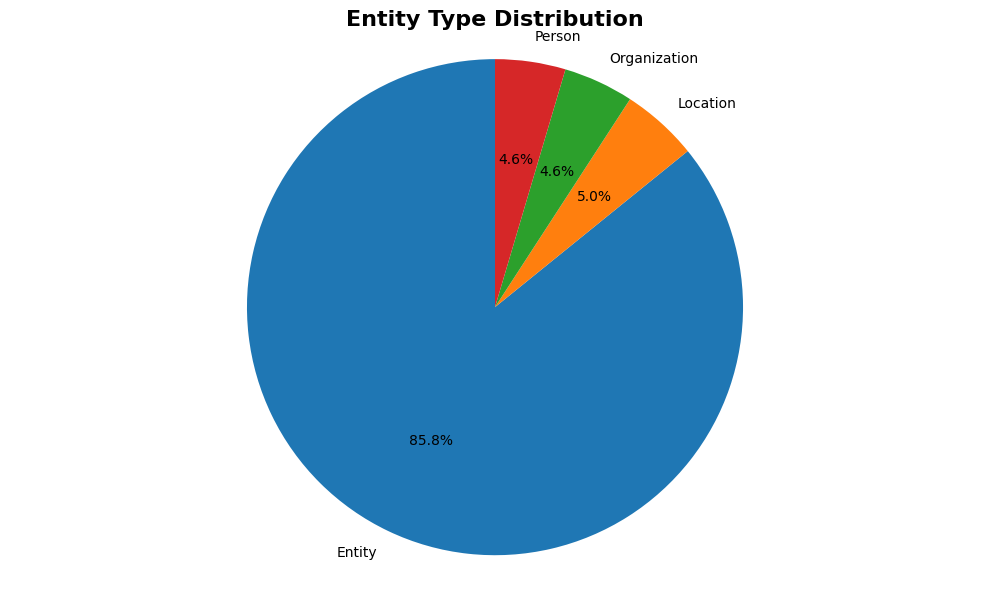


✓ Chart saved to media/entity_type_distribution.png


In [12]:
# Query 3: Entity type distribution
print("\n3️⃣ Entity type distribution:")
query3 = """
MATCH (e:Entity)
RETURN e.type as entity_type, count(e) as count
ORDER BY count DESC
"""
type_dist = run_cypher(query3)
display(type_dist)

# Visualize distribution
if not type_dist.empty:
    plt.figure(figsize=(10, 6))
    plt.pie(type_dist['count'], labels=type_dist['entity_type'], autopct='%1.1f%%', startangle=90)
    plt.title('Entity Type Distribution', fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('/workspace/media/entity_type_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Chart saved to media/entity_type_distribution.png")

## 5. Setup LangChain with Ollama

In [13]:
# Initialize Neo4j Graph for LangChain
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USER,
    password=NEO4J_PASSWORD
)

print("✓ Neo4j Graph initialized for LangChain")
print("\n📋 Graph Schema:")
print(graph.schema)

✓ Neo4j Graph initialized for LangChain

📋 Graph Schema:
Node properties:
Entity {type: STRING, name: STRING, salience: FLOAT}
Person {type: STRING, name: STRING, salience: FLOAT}
Organization {type: STRING, salience: FLOAT, name: STRING}
Location {type: STRING, salience: FLOAT, name: STRING}
Article {summary: STRING, loaded_at: DATE_TIME, title: STRING, url: STRING}
Relationship properties:
MENTIONS {salience: FLOAT}
The relationships:
(:Article)-[:MENTIONS]->(:Entity)
(:Article)-[:MENTIONS]->(:Person)
(:Article)-[:MENTIONS]->(:Organization)
(:Article)-[:MENTIONS]->(:Location)


## 5. Setup LangChain with Ollama

In [14]:
# Initialize Ollama LLM
try:
    llm = ChatOllama(
        base_url=OLLAMA_BASE_URL,
        model=OLLAMA_MODEL,
        temperature=0
    )
    
    # Test the LLM
    response = llm.invoke("Say 'Hello from Ollama!'")
    print("✓ Ollama LLM initialized successfully")
    print(f"  Test response: {response.content}")
    
except Exception as e:
    print(f"✗ Failed to initialize Ollama: {e}")
    print("\n⚠️ Make sure Ollama is running locally and the model is pulled:")
    print(f"  ollama pull {OLLAMA_MODEL}")

✓ Ollama LLM initialized successfully
  Test response: Hello from Ollama! 👋



In [ ]:
# Create custom prompt for Cypher generation (Stage 1)
CYPHER_GENERATION_TEMPLATE = """Task: Generate Cypher statement to query a graph database.

Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:
{question}
"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"],
    template=CYPHER_GENERATION_TEMPLATE
)

# Create custom prompt for Answer Generation (Stage 2)
# This prompt explains the task and provides schema context
QA_GENERATION_TEMPLATE = """You are analyzing results from a Neo4j graph database query.

Graph Schema:
{schema}

A Cypher query was executed to answer the following question, and returned the results below.

Question: {question}

Query Results: {context}

Based on the query results, provide a direct answer to the question. 
Interpret the data values correctly - look at the actual numbers in the results.

Answer:"""

# Format the QA prompt with the schema embedded
# (since GraphCypherQAChain only provides question and context to qa_prompt)
QA_PROMPT_WITH_SCHEMA = QA_GENERATION_TEMPLATE.format(schema=graph.schema, question="{question}", context="{context}")

QA_PROMPT = PromptTemplate(
    input_variables=["question", "context"],
    template=QA_PROMPT_WITH_SCHEMA
)

# Create the chain with both prompts
try:
    cypher_chain = GraphCypherQAChain.from_llm(
        llm=llm,
        graph=graph,
        cypher_prompt=CYPHER_GENERATION_PROMPT,
        qa_prompt=QA_PROMPT,
        verbose=True,
        return_intermediate_steps=True,
        allow_dangerous_requests=True
    )
    
    print("✓ GraphCypherQAChain created successfully")
    print("  Stage 1: Cypher generation (with schema)")
    print("  Stage 2: Answer generation (with schema + interpretation instructions)")
    
except Exception as e:
    print(f"✗ Failed to create chain: {e}")

## 7. Natural Language Querying

In [16]:
# Helper function to query the knowledge graph with natural language
def ask_graph(question):
    """Ask a question in natural language"""
    print(f"\n❓ Question: {question}")
    print("=" * 80)
    
    try:
        result = cypher_chain.invoke({"query": question})
        
        print("\n🔍 Generated Cypher:")
        if 'intermediate_steps' in result:
            for step in result['intermediate_steps']:
                if 'query' in step:
                    print(f"  {step['query']}")
        
        print("\n💡 Answer:")
        print(f"  {result['result']}")
        
        return result
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        return None

In [ ]:
# Example Question 1: Count articles
ask_graph("How many articles are in the knowledge graph?")


❓ Question: How many articles are in the knowledge graph?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (a:Article) RETURN count(a)

Full Context:
[{'count(a)': 3}]


In [42]:
# Example Question 2: List entities
ask_graph("What are the names of all the people mentioned in the articles?")


❓ Question: What are the names of all the people mentioned in the articles?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (articles:Article)<-[:MENTIONS]-(entities:Entity),
       articles<-[:MENTIONS]-(persons:Person),
       articles<-[:MENTIONS]-(organizations:Organization),
       articles<-[:MENTIONS]-(locations:Location)
RETURN DISTINCT persons.name AS person_names


❌ Error: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'articles': expected "(", "ALL", "ANY" or "SHORTEST" (line 3, column 8 (offset: 71))
"       articles<-[:MENTIONS]-(persons:Person),"
        ^}


In [ ]:
# Example Question 3: Find connections
ask_graph("Which articles mention organizations?")

In [ ]:
# Example Question 4: Most mentioned entities
ask_graph("What are the most frequently mentioned entities across all articles?")

In [ ]:
# Example Question 5: Custom question
# Add your own questions here!
ask_graph("What locations are mentioned in the knowledge graph?")

## 8. Entity Summarization Helper

In [ ]:
# Create entity summarization function
def summarize_entity(entity_name):
    """Get a comprehensive summary of an entity from the knowledge graph"""
    query = """
    MATCH (e:Entity {name: $entity_name})
    OPTIONAL MATCH (a:Article)-[m:MENTIONS]->(e)
    RETURN e.name as name, e.type as type,
           collect(DISTINCT a.title) as mentioned_in,
           count(DISTINCT a) as article_count,
           avg(m.salience) as avg_salience
    """
    
    with driver.session() as session:
        result = session.run(query, entity_name=entity_name)
        record = result.single()
        
        if not record:
            print(f"❌ Entity '{entity_name}' not found")
            return None
        
        print(f"\n📌 Entity: {record['name']}")
        print(f"   Type: {record['type']}")
        print(f"   Mentioned in {record['article_count']} article(s)")
        print(f"   Average salience: {record['avg_salience']:.3f}")
        print(f"   Articles: {', '.join(record['mentioned_in'])}")
        
        return dict(record)

# Test with the first entity
test_entities = get_top_entities(limit=1)
if not test_entities.empty:
    summarize_entity(test_entities.iloc[0]['name'])

## 9. Advanced RAG: Combining Context with Queries

In [ ]:
# Advanced RAG function that combines graph queries with article context
def rag_query(question):
    """Perform RAG query combining graph structure and article content"""
    print(f"\n🔎 RAG Query: {question}")
    print("=" * 80)
    
    # Step 1: Use GraphCypherQAChain to get structured data
    try:
        graph_result = cypher_chain.invoke({"query": question})
        graph_context = graph_result['result']
        print("\n✓ Retrieved structured data from graph")
    except Exception as e:
        print(f"⚠️ Graph query failed: {e}")
        graph_context = "No structured data available."
    
    # Step 2: Get relevant article summaries
    articles_query = """
    MATCH (a:Article)
    RETURN a.title as title, a.summary as summary
    LIMIT 3
    """
    
    with driver.session() as session:
        result = session.run(articles_query)
        articles = [dict(record) for record in result]
    
    article_context = "\n".join([
        f"- {a['title']}: {a['summary'][:200]}..."
        for a in articles
    ])
    
    print("✓ Retrieved unstructured context from articles")
    
    # Step 3: Combine contexts and query LLM
    rag_prompt = f"""
Based on the following information from a knowledge graph and article summaries, 
please answer this question: {question}

Structured data from graph:
{graph_context}

Article summaries:
{article_context}

Please provide a comprehensive answer based on both sources.
    """
    
    try:
        response = llm.invoke(rag_prompt)
        print("\n💡 RAG Answer:")
        print(f"  {response.content}")
        return response.content
    except Exception as e:
        print(f"\n❌ LLM query failed: {e}")
        return None

In [ ]:
# Test RAG query
rag_query("What are the main topics covered in the knowledge graph and how are they related?")

## 10. Summary and Conclusions

In [ ]:
# Generate final summary
print("\n" + "=" * 80)
print("📊 TP5 SUMMARY")
print("=" * 80)

stats = get_graph_stats()
print("\n✅ Knowledge Graph Built Successfully:")
for label, count in stats.items():
    print(f"  • {label}: {count}")

print("\n🎯 Key Achievements:")
print("  1. Loaded Wikipedia articles into Neo4j")
print("  2. Extracted entities and relationships using Diffbot/LLM")
print("  3. Created an interactive knowledge graph")
print("  4. Implemented natural language querying with Ollama + LangChain")
print("  5. Built a RAG system combining structured and unstructured data")

print("\n📁 Generated Outputs:")
print("  • media/graph_statistics.png")
print("  • media/entity_type_distribution.png")
print("  • media/knowledge_graph.html")

print("\n" + "=" * 80)
print("✨ TP5 Complete!")
print("=" * 80)

In [ ]:
# Clean up
driver.close()
print("\n✓ Neo4j connection closed")